<a href="https://colab.research.google.com/github/Machine-Learning-Tokyo/MLT-x-fastai/blob/master/mini-lessons/text/ymr_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.text import *

## Language Modeling

One of the most common tasks done in NLP is called language modeling. A language model is an NLP model which learns to predict the next word in a sentence. We do this is because we assume that if a language model is quite accurate at guessing the next probable word in a sentnce, it needs a lot of world knowledge and a deep understanding of grammar, semantics, and other elements of natural language.

We will show how to train a simple language model.


In [0]:
#install  mecab dependencies
#!sudo apt install swig
#!sudo apt install mecab
#!sudo apt install libmecab-dev
#!sudo apt install mecab-ipadic-utf8
#!sudo pip3 install mecab-python3

In [0]:
import re
import MeCab

tagger = MeCab.Tagger("-Owakati")

class MeCabTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = 'ja'
    
    def add_special_cases(self, toks:Collection[str]): pass
    
    def tokenizer(self,raw_sentence):
        result = tagger.parse(raw_sentence)
        words = result.split()
        if len(words) == 0:
            return []
        if words[-1] == "\n":
            words = words[:-1]
        return words

## Tokenization and Numericalization

The most common preprocessing on NLP tasks in tokenization i.e splitting the sentence into words. This is much easier in space-seperated words like English however, for Japanese we require Morphological Analysis tools to get words from sentences.

Numericalizing in the second preprocessing step. Since models can only take numbers as inputs, we make a dictionary mapping unique words to indices and replace the words with the words in the sentence with their corresponding index. Here we limit our dictionary size to 60000 words that appear at least twice in our corpus.


In [0]:
tokenizer = Tokenizer(MeCabTokenizer, 'ja')
processor = [TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=60000,min_freq=2)]

In [0]:
#get data
#!wget https://github.com/dennybritz/sentiment-analysis/raw/master/data/yahoo-movie-reviews.json.tar.gz
#!mkdir data
#!tar xvzf yahoo-movie-reviews.json.tar.gz

In [0]:
path = Path("data")

In [0]:

def load_ymr_data(path):
    with path.open() as f:
        data = pd.read_json(f)
        data.movieName = data.movieName.str.strip()
        data.text = data.text.str.strip()
        data.title = data.title.str.strip()
        data = data[data.text.str.len() > 0]
        data.url = data.url.str.strip()
    return data

def make_polar(data, balance=True):
    data_polar = data.loc[data.rating != 3].copy()
    data_polar.loc[data_polar.rating <= 2, 'rating'] = 0
    data_polar.loc[data_polar.rating >= 4, 'rating'] = 1
    if balance:
        # Subsample - We want the same number of positive and negative examples
        grouped_ratings = data_polar.groupby('rating')
        K = grouped_ratings.rating.count().min()
        indices = itertools.chain(
            *[np.random.choice(v, K, replace=False) for k, v in grouped_ratings.groups.items()])
        data_polar = data_polar.reindex(indices).copy()
    return data_polar


mov_df = load_ymr_data(path/'yahoo-movie-reviews.json')
mov_df_polar = make_polar(mov_df)
mov_df_polar.head()

,movieName,movieUrl,url,title,date,text,rating
59664,レッドクリフ Part I,http://movies.yahoo.co.jp/movie/%E3%83%AC%E3%8...,http://movies.yahoo.co.jp/movie/%E3%83%AC%E3%8...,ワールドワイドだとしても,2009年4月12日 0時30分,こんなに薄っぺらい三国志は初めてだ。\n曹操が女だけが目的であるかのような描き方、もちろんそ...,0
32141,スラムドッグ＄ミリオネア,http://movies.yahoo.co.jp/movie/%E3%82%B9%E3%8...,http://movies.yahoo.co.jp/movie/%E3%82%B9%E3%8...,化粧版仕立てのあんちょこ話,2009年5月2日 3時44分,書く気持ちは無かった だって・・腹を立てる程のレベルでもなかったんで・・\nほんっとに 述べ...,0
68237,悪人,http://movies.yahoo.co.jp/movie/%E6%82%AA%E4%B...,http://movies.yahoo.co.jp/movie/%E6%82%AA%E4%B...,う～ん,2011年11月6日 23時43分,賞取ってみたり、話題になった割には何か偏った内容で納得行かない。\n\n殺された子が、いかに...,0
18182,インディ・ジョーンズ／クリスタル・スカルの王国,http://movies.yahoo.co.jp/movie/%E3%82%A4%E3%8...,http://movies.yahoo.co.jp/movie/%E3%82%A4%E3%8...,別物,2008年7月20日 20時56分,別物として観れば星ひとつで観れる。,0
52213,ブラック・スワン,http://movies.yahoo.co.jp/movie/%E3%83%96%E3%8...,http://movies.yahoo.co.jp/movie/%E3%83%96%E3%8...,高評価過ぎませんか？？,2011年5月15日 20時22分,確かに、大画面、大音響でのバレエシーンは迫力がありましたが、はっきり言って私にはそれだけでし...,0


In [0]:
sample_df = mov_df_polar.sample(n=1000,replace=True)
sample_df.head()

,movieName,movieUrl,url,title,date,text,rating
58075,ミスト,http://movies.yahoo.co.jp/movie/%E3%83%9F%E3%8...,http://movies.yahoo.co.jp/movie/%E3%83%9F%E3%8...,怖い,2014年2月3日 1時14分,スティーブン・キング原作のこの物語は、キングが30歳頃の時に書かれた作品で、書き直しを数度経...,1
41953,トランスフォーマー,http://movies.yahoo.co.jp/movie/%E3%83%88%E3%8...,http://movies.yahoo.co.jp/movie/%E3%83%88%E3%8...,映像ド迫力!!,2007年8月10日 14時26分,映像ド迫力！\nトランスフォームしてるところがガチャガチャしすぎて目が痛い感じだけど、ストー...,1
44173,バベル,http://movies.yahoo.co.jp/movie/%E3%83%90%E3%8...,http://movies.yahoo.co.jp/movie/%E3%83%90%E3%8...,日本の女子高生はこんなに破廉恥か？,2007年5月4日 23時47分,バベルという題名から、異なる”言語”と”国又は民族がテーマなのだろうと言う事は想像がつきまし...,0
164,おくりびと,http://movies.yahoo.co.jp/movie/%E3%81%8A%E3%8...,http://movies.yahoo.co.jp/movie/%E3%81%8A%E3%8...,おくられびと,2008年9月13日 21時46分,客層がとても高くて驚きました。平均年齢６５歳以上でした。しかもほぼ満席。\nみなさん、もしや...,1
34284,ゼロ・グラビティ,http://movies.yahoo.co.jp/movie/%E3%82%BC%E3%8...,http://movies.yahoo.co.jp/movie/%E3%82%BC%E3%8...,所詮ハリウッド映画,2014年1月2日 12時55分,ある程度、SFや宇宙飛行に詳しい人が見るとガッカリします。\n「プラネテス」ぐらいのリアリテ...,0


In [0]:
len(sample_df[sample_df["rating"]==0])

483

In [0]:
len(sample_df)

1000

In [0]:
data_lm = (TextList.from_df(sample_df,path,cols='text',processor=processor)
                .split_by_rand_pct()
                .label_for_lm()
                .databunch())

In [0]:
data_lm.show_batch()

idx,text
0,は 「 霧 の 中 」 という 題名 だっ た よう に 記憶 し て い ます 。 この 後 、 1980 年 以後 は 「 霧 」 で xxunk さ れ て いる よう です 。 キング が 乗り に 乗っ て い た の は 、 やはり 30 歳 台 で 、 この 時期 に 活き の 良い 作品 を xxunk まし た 。 「 霧 」 は
1,の かも しれ ませ ん 。 宮崎 駿 さん の 作品 に は 感じる こと の ない 自分 の 気持ち を 置い て け ぼり に さ れ た 、 なんだか とっても 不思議 な 気持ち に なり まし た 。 xxbos ちょっと 興奮 冷め やら ぬ 状態 で 書き ます が * 1 、 『 ベイ マックス 』 が とにかく 最高 だっ た ！ ！ ！ 原作 は マーベルコミック の
2,な 方 は 大体 亡くなっ た ので 後編 の キャスト に 期待 し ます 。 xxbos まぁ 、 予告編 とか 、 いっぱい ある けど 、 何 も 言わ ず に まず は 見 ましょ う 。 日本 映画 が ダメ だ と 思っ てる 人 も 、 まず 見 て み ましょ う 。 絶対 、 涙腺 に くる はず です 。 xxbos もう 絶対 と いっ て xxunk ませ
3,【 主人公 の 妄想 だっ た という 結末 】 は 、 そう xxunk れ て いる だけ な の かも ？ そう なる と 、 xxunk 宣伝 や 予告 も 嘘 で は なくなっ て くる 。 xxunk 、 xxunk 制作 者 の 意図 に はまっ て しまっ た か ・ ・ ・ 。 xxbos 正直 期待 はずれ でし た 。 戦争 の 実写 映像 見 てる 方 が よっぽど
4,動機 は はっきり し ませ ん が 、 竹中 裁判官 は 「 xxunk 公害 xxunk 」 など 、 住民 寄り の 判決 を 出す こと で 有名 な 方 だっ た こと から 見え ない 圧力 の 存在 を xxunk し て しまい ます 。 公務員 で ある 彼ら にとって 国家 権力 に xxunk を xxunk こと は xxunk 知れ ない xxunk が ある こと は 確か だ と 思い


In [0]:
config = awd_lstm_lm_config.copy()
config["n_hid"] = 1150

In [0]:
#mounting your drive
#from google.colab import drive
#drive.mount('/content/gdrive')

You can download the pretrained model file from this [link](https://drive.google.com/open?id=1KRUEV_3R-JVhcftvWJ66rwU7e_EZWtxE). Make sure to put them in your `path/models/` folder.

In [0]:
learn = language_model_learner(data_lm,arch=AWD_LSTM,config=config,
                               drop_mult=0.3,pretrained_fnames=['ja-wiki','ja-wiki-itos'])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


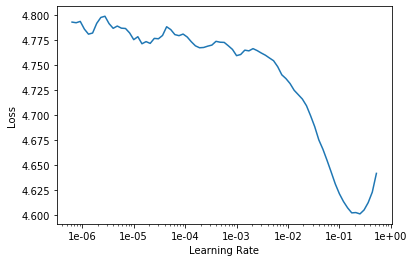

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.524120,4.142681,0.273270,00:03


In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.225604,4.092703,0.277958,00:05
1,4.168275,4.006522,0.283817,00:05
2,4.076260,3.939052,0.290765,00:05
3,3.952452,3.894985,0.294587,00:05
4,3.809502,3.870207,0.295592,00:05
5,3.667592,3.866823,0.294196,00:05
6,3.523893,3.872233,0.293694,00:05
7,3.403836,3.878788,0.293359,00:05
8,3.322362,3.887154,0.292690,00:05
9,3.260335,3.889102,0.292271,00:05


In [0]:
learn.save_encoder("encoder")

In [0]:
learn.predict("この映画を見て思ったのは", 70)

'この映画を見て思ったのは 「 もっと 大 成功 だっ た ！ 」 と 思っ た と 思い ます 。 自分 の 年齢 が わから ず に 生まれ た 年代 が まだ 読め て い ない 。 そして 最後 の 世代 は すでに 300 歳 以上 の 年齢 しか あり ませ ん でし た 、 （ 19 全体 の 年齢 不明 ） 20 歳 物語 で は 、 大人 に なっ た 数 年 前'

## Text Classification

One particular area that was challenging until recently with deep learning for NLP, was text classification.

Similar to classifying images in text we can also use transfer learning to train accurate classifiers with few training examples. We will leverage weights from a language model trained on a large corpus as our pretrained weights. We will fine-tune the language model to our target dataset, attach a classification layer to our model and train by gradual unfreezing. The text classifying task will be sentiment analysis on Yahoo Movie Reviews.


In [0]:
data_clas = (TextList.from_df(sample_df,path,cols="text",vocab=data_lm.vocab,processor=processor)
             .split_by_rand_pct()
             .label_from_df("rating")
             .databunch())

In [0]:
data_clas.show_batch()

text,target
xxbos この 作品 は 興味 重々 で は 有っ た の です が 、 なかなか 観る 事 は xxunk れ まし た 。 と 言う の も 、 個人 的 な xxunk 思い出 が 、 それ も 近い xxunk で xxunk 有っ た から です 。 私 は 、 数 年 前 、 幾 年 か の xxunk を 経 て 、 結婚 し た わけ です が 、 妻,1
xxbos 残念 ながら 、 レビュー を 見る と 、 続編 は 作る な と の 声 が 多い 様 で ある 。 前作 に 於い て も 、 続編 を 作る こと へ の 懸念 が 相当 あっ た 。 それ は 、 感動 が 台無し に さ れる こと へ の 恐れ から で あろ う 。 私 は 、 その 様 な ネガティブ な 考え は 好き じゃ,1
xxbos 『 m : i - 2 』 など の 巨匠 ジョン ・ ウー 監督 作品 。 （ １ ０ 億 円 も の xxunk を 投じ た そう です ^^;） 「 三国志 」 の 有名 な xxunk 「 赤 壁 の 戦い 」 を 映画 化 し た 壮大 な スケール の 歴史 スペクタクル 大作 。 「 三国志 」 って 、 小学生 の 時 ・ ・ ・ 学校 の,1
xxbos 舞台 は 、 東京 オリンピック xxunk を xxunk に xxunk た １ ９ ６ ３ 年 。 高度 経済 成長 の 走り で 、 xxunk は xxunk ものの 、 ６ ０ 年 安保 や 、 戦後 の 余韻 が まだ 残っ て いる 時代 の ころ 。 一方 で 、 多数 の 煙突 は 、 その後 、 公害 が 社会 問題 化 し て いく こと を も 象徴,1
xxbos 方々 で 酷評 さ れ て い た ので 、 他 に xxunk もの も 無い ので 期待 せ ず に レンタル し て 鑑賞 し まし た 。 予想 通り という か 、 酷い 出来 です 。 どこ が 悪い の か という こと を 、 具体 的 に うまく 表現 する の は 、 難しい の です が 、 xxunk 「 センス が ない 」 という 表現,0


In [0]:
config = awd_lstm_clas_config.copy()
config["n_hid"] = 1150

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM,config=config,drop_mult=0.5)
learn.load_encoder("encoder")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


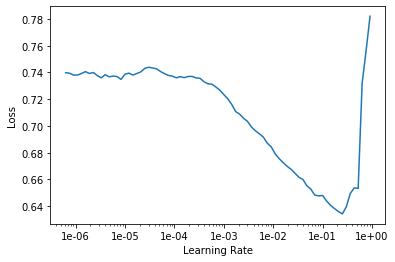

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.658073,0.665492,0.585000,00:03


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.570638,0.610348,0.695000,00:03


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.489625,0.590400,0.695000,00:05


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.445758,0.580102,0.700000,00:07
1,0.429772,0.573574,0.725000,00:07


In [0]:
learn.predict("演技が悪かった")

(Category 0, tensor(0), tensor([0.9082, 0.0918]))